<a href="https://colab.research.google.com/github/sznajder/ON-Minicurso-2022/blob/main/VAE_MNIST_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**VAE on a MNIST dataset**


In [36]:
# prerequisites
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import binary_crossentropy
from scipy.stats import norm

In [37]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

# network parameters
batch_size, n_epoch = 100, 10
n_hidden, z_dim = 256, 2

(60000, 784) (10000, 784)


In [38]:
# encoder
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)

In [39]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

In [40]:
# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

In [41]:
# VAE loss with KL divergence 
reconstruction_loss = binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

# build model
vae = Model(x, y)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_21 (Dense)               (None, 256)          200960      ['input_4[0][0]']                
                                                                                                  
 dense_22 (Dense)               (None, 128)          32896       ['dense_21[0][0]']               
                                                                                                  
 dense_23 (Dense)               (None, 2)            258         ['dense_22[0][0]']               
                                                                                            

In [42]:
# train
vae.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)

Epoch 1/10
600/600 [==============================] - 4s 4ms/step - loss: 185.0352 - val_loss: 169.0368
Epoch 2/10
600/600 [==============================] - 2s 4ms/step - loss: 164.3731 - val_loss: 159.6756
Epoch 3/10
600/600 [==============================] - 2s 4ms/step - loss: 156.2923 - val_loss: 154.2896
Epoch 4/10
600/600 [==============================] - 2s 4ms/step - loss: 152.2388 - val_loss: 151.3405
Epoch 5/10
600/600 [==============================] - 3s 4ms/step - loss: 149.6421 - val_loss: 149.6764
Epoch 6/10
600/600 [==============================] - 3s 4ms/step - loss: 147.7575 - val_loss: 147.8333
Epoch 7/10
600/600 [==============================] - 2s 4ms/step - loss: 146.2007 - val_loss: 146.8181
Epoch 8/10
600/600 [==============================] - 3s 6ms/step - loss: 145.1666 - val_loss: 145.2214
Epoch 9/10
600/600 [==============================] - 3s 5ms/step - loss: 144.1326 - val_loss: 144.6397
Epoch 10/10
600/600 [==============================] - 3s 5ms/st

In [43]:
# build encoder
encoder = Model(x, mu)
encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_21 (Dense)            (None, 256)               200960    
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 2)                 258       
                                                                 
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


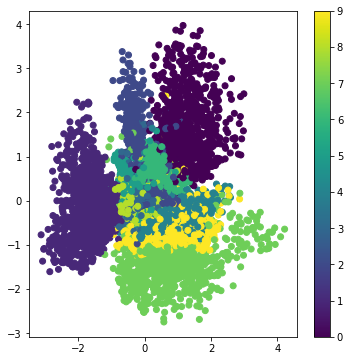

In [44]:
# Plot of the digit classes in the latent space
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()

In [45]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_25 (Dense)            multiple                  384       
                                                                 
 dense_26 (Dense)            multiple                  33024     
                                                                 
 dense_27 (Dense)            multiple                  201488    
                                                                 
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


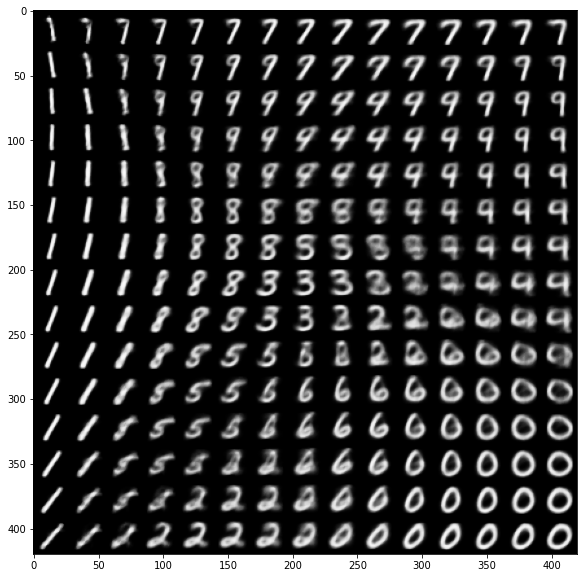

In [46]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

**Plot the Input and Reconstructed digits**

In [47]:
'''
############################################################################
# Visualize the reconstructed inputs and the encoded representations
# encode and decode some digits ( note that we take them from the *test* set )

# use Matplotlib

num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_te.shape[0], size=num_images)

#encoded_imgs = encoder.predict(x_te)
#decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs = vae.predict(x_te.shape[1:])

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_te[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot encoded image
#    ax = plt.subplot(3, num_images, num_images + i + 1)
#    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
#    plt.gray()
#    ax.get_xaxis().set_visible(False)
#    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
'''

'\n############################################################################\n# Visualize the reconstructed inputs and the encoded representations\n# encode and decode some digits ( note that we take them from the *test* set )\n\n# use Matplotlib\n\nnum_images = 10\nnp.random.seed(42)\nrandom_test_images = np.random.randint(x_te.shape[0], size=num_images)\n\n#encoded_imgs = encoder.predict(x_te)\n#decoded_imgs = decoder.predict(encoded_imgs)\ndecoded_imgs = vae.predict(x_te.shape[1:])\n\nplt.figure(figsize=(18, 4))\n\nfor i, image_idx in enumerate(random_test_images):\n    # plot original image\n    ax = plt.subplot(3, num_images, i + 1)\n    plt.imshow(x_te[image_idx].reshape(28, 28))\n    plt.gray()\n    ax.get_xaxis().set_visible(False)\n    ax.get_yaxis().set_visible(False)\n\n    # plot encoded image\n#    ax = plt.subplot(3, num_images, num_images + i + 1)\n#    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))\n#    plt.gray()\n#    ax.get_xaxis().set_visible(False)\n#    ax.